In [18]:
# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

from pepe.preprocess import circularMask, crossMask, mergeMasks
from pepe.simulate import genSyntheticResponse
from pepe.analysis import initialForceSolve, forceOptimize

import numpy as np

#from scipy.optimize import minimize, leastsq
from lmfit import minimize, Parameters, fit_report

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 110

from IPython.display import clear_output

# For timing
import time

## Generate the system

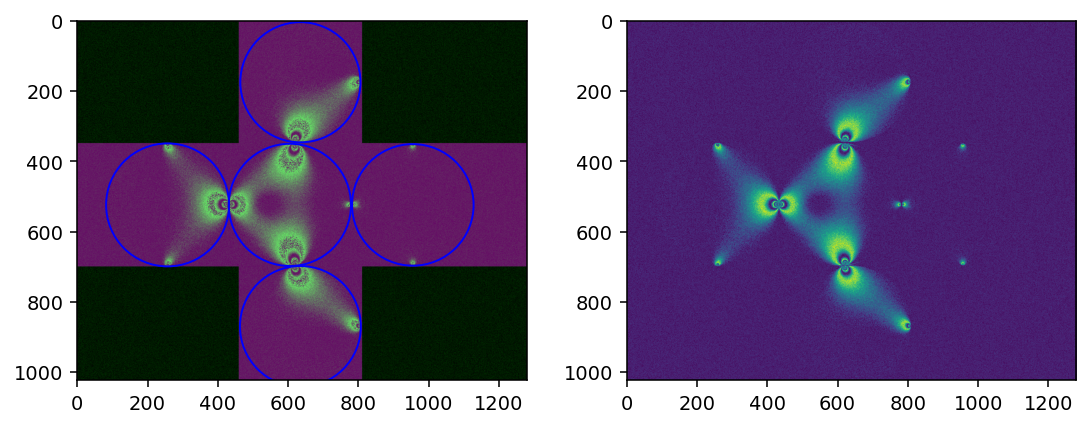

In [15]:
# Make some fake data with interparticle and wall contacts
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

fSigma = 100.
pxPerMeter = 10000.
brightfield = False

imageShape = (1024, 1280, 3)

# Create a cross-shaped channel
maskArr = crossMask(imageShape, xlim=np.array([460, 810]), ylim=np.array([350, 700]))

# Our particles
centers = np.array([[524, 257], [524, 605], [524, 955], # Center particles
                   [175, 635], [870, 635]]) # Top and bottom particles
radii = np.array([175, 174, 173, 171, 172]) # Odd numbers are good

# Make some fake stress patterns, which we will try to recover later on (but these are normally unknown)
# Same order as the order of centers above
# Made by just messing around with numbers until things look good
forces = np.array([[.08, .1, .4], [.4, .05, .32, .39], [.06, .05, .05], [.37, .15], [.35, .16]], dtype='object')
betas = np.array([[0., np.pi, np.pi/2], [.1, np.pi/2, -np.pi/2, np.pi-.1], [-np.pi/2, 0., np.pi], [-.1, np.pi/2], [-np.pi+.1, np.pi/2]], dtype='object')
alphas = np.array([[0., 0., 0.], [np.pi-.2, 0., 0., .2], [0., 0., 0.], [.2, 0.], [np.pi-.2, 0.]], dtype='object')

photoelasticChannel = np.zeros(imageShape[:2])

for i in range(len(centers)):
    photoelasticChannel += genSyntheticResponse(np.array(forces[i]), np.array(alphas[i]), np.array(betas[i]), fSigma, radii[i], pxPerMeter, brightfield, imageSize=imageShape[:2], center=centers[i])

# Optional: add some noise to the photoelastic channel
photoelasticChannel += np.random.uniform(-.2, .2, size=photoelasticChannel.shape)

photoelasticChannel = np.abs(photoelasticChannel)

compositeImage = np.zeros(imageShape, dtype=np.uint8)
compositeImage[:,:,0] = maskArr[:,:,0]*100
compositeImage[:,:,1] = np.uint8(photoelasticChannel*255)
compositeImage[:,:,2] = maskArr[:,:,0]*100

ax[0].imshow(compositeImage)
for i in range(len(centers)):
    c = plt.Circle(centers[i][::-1], radii[i], label='Detected particles', color='blue', fill=False)
    ax[0].add_artist(c)
    
ax[1].imshow(photoelasticChannel)
fig.tight_layout()
plt.show()

## Find initial guess

In [16]:
# Parameters of our force solving method
contactPadding = 10
g2MaskPadding = 1
contactMaskRadius = 50

forceGuessArr, alphaGuessArr, betaGuessArr = initialForceSolve(photoelasticChannel,
                                                centers, radii, fSigma, pxPerMeter,
                                                contactPadding, g2MaskPadding,
                                                contactMaskRadius=contactMaskRadius,
                                                boundaryMask=maskArr, ignoreBoundary=False)

## Show initial guess

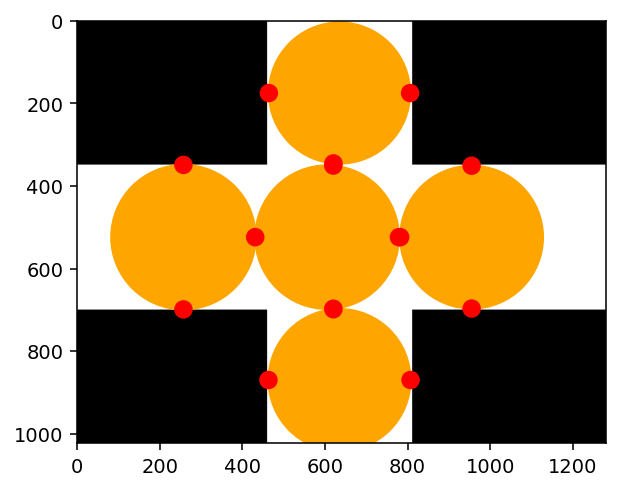

In [4]:
# Draw on all of the found contacts
fig, ax = plt.subplots()

ax.imshow(maskArr*255)

for i in range(len(centers)):
    # particle itself
    c = plt.Circle(centers[i][::-1], radii[i], label='Detected particle', color='orange')
    ax.add_artist(c)
    
    # Now add contacts
    for j in range(len(betaGuessArr[i])):
        contactPoint = centers[i] + radii[i] * np.array([np.cos(betaGuessArr[i][j]), np.sin(betaGuessArr[i][j])])
        #linePoints = np.array([centers[i], radii[i] * np.array([np.cos(betaGuessArr[i][j]), np.sin(betaGuessArr[i][j])])])
        #plt.plot(linePoints[0], linePoints[1], color='blue')
        cc = plt.Circle(contactPoint[::-1], 20, color='red')
        ax.add_artist(cc)
        
plt.show()

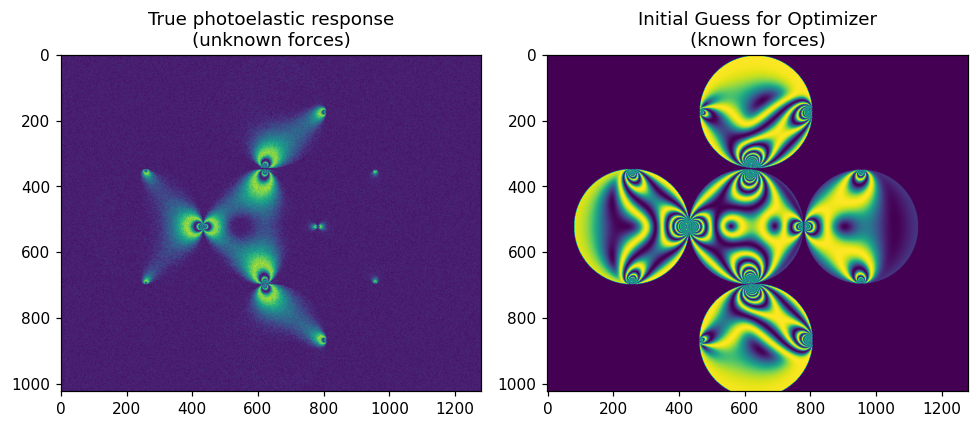

79503.02746833056


In [26]:
fig, ax = plt.subplots(1, 2, figsize=(9,7))

ax[0].imshow(photoelasticChannel)
ax[0].set_title('True photoelastic response\n(unknown forces)')

estimatedPhotoelasticChannel = np.zeros(imageShape[:2])
estimatedPhotoelasticChannel2 = np.zeros(imageShape[:2])

for i in range(len(centers)):
    estimatedPhotoelasticChannel += genSyntheticResponse(np.array(forceGuessArr[i]),
                                                         np.array(alphaGuessArr[i]),
                                                         np.array(betaGuessArr[i]),
                                                         fSigma, radii[i], pxPerMeter, brightfield, imageSize=imageShape[:2], center=centers[i])
ax[1].imshow(estimatedPhotoelasticChannel)
ax[1].set_title('Initial Guess for Optimizer\n(known forces)')

fig.tight_layout()
#plt.savefig('../images/initial_guess_noise.png')
plt.show()

print(np.sum(estimatedPhotoelasticChannel - photoelasticChannel))

## Optimize forces

In [13]:
# Now optimize each particle's forces
optimizedForceArr = []
optimizedBetaArr = []
optimizedAlphaArr = []

for i in range(len(centers)):
    optForceArr, optBetaArr, optAlphaArr, res = forceOptimize(np.zeros(len(forceGuessArr[i]))+.1, betaGuessArr[i], alphaGuessArr[i], radii[i], centers[i], photoelasticChannel,
                                                              fSigma, pxPerMeter, brightfield, maxEvals=150, method='nelder',
                                                              parametersToFit=[['f', 'b'], ['f', 'a']])
    optimizedForceArr.append(optForceArr)
    optimizedBetaArr.append(optBetaArr)
    optimizedAlphaArr.append(optAlphaArr)

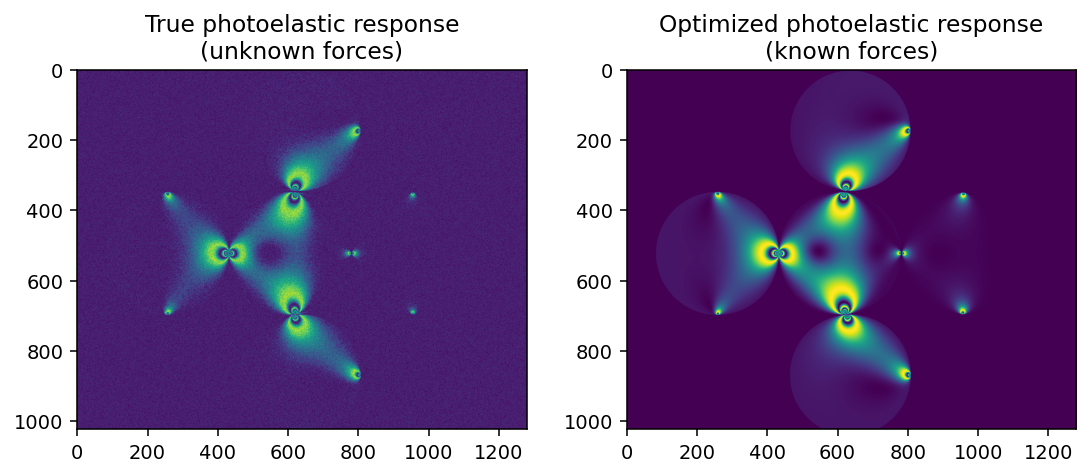

Absolute error (entire system): -98560.05914175403


In [14]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(photoelasticChannel)
ax[0].set_title('True photoelastic response\n(unknown forces)')

optimizedPhotoelasticChannel = np.zeros(imageShape[:2])

for i in range(len(centers)):
    optimizedPhotoelasticChannel += genSyntheticResponse(np.array(optimizedForceArr[i]),
                                                         np.array(optimizedAlphaArr[i]),
                                                         np.array(optimizedBetaArr[i]),
                                                         fSigma, radii[i], pxPerMeter, brightfield, imageSize=imageShape[:2], center=centers[i])


ax[1].imshow(optimizedPhotoelasticChannel)
ax[1].set_title('Optimized photoelastic response\n(known forces)')

fig.tight_layout()
plt.show()

print(f'Absolute error (entire system): {np.sum(optimizedPhotoelasticChannel - photoelasticChannel)}')

### Optimization using scipy

In [17]:
# Now try to actually perform some optimization to get a better result

# By default, we only fit alpha and the force magnitude
fitBeta = False

optimizedForceArr = np.array([np.zeros(len(forceGuessArr[i])) for i in range(len(centers))], dtype='object')
optimizedBetaArr = np.array([np.zeros(len(forceGuessArr[i])) for i in range(len(centers))], dtype='object')
optimizedAlphaArr = np.array([np.zeros(len(forceGuessArr[i])) for i in range(len(centers))], dtype='object')

# Setup our function based on what parameters we are fitting
# We want to avoid any if statements within the function itself, since
# that will be evaluated many many times

# x is a vector of max length 3*z, in which the first z elements are forces, next z elements
# are betas, and final z elements are alphas (assuming all 3 parameters are being fitted)
if fitBeta:
    def objectiveFunction(x, trueImage, z, radius, center):
        forceArr = np.array(x[:z])
        betaArr = np.array(x[z:2*z])
        alphaArr = np.array(x[2*z:])
        #print(forceArr, betaArr, alphaArr)
        synImage = genSyntheticResponse(forceArr, betaArr, alphaArr, fSigma, radii[i], pxPerMeter, brightfield, imageSize=imageShape[:2], center=centers[i])
        return np.sum(synImage - trueImage)
else:
    def objectiveFunction(x, trueImage, betaArr, z, radius, center):
        forceArr = np.array(x[:z])
        alphaArr = np.array(x[z:])
        #print(forceArr, betaArr, alphaArr)
        synImage = genSyntheticResponse(forceArr, betaArr, alphaArr, fSigma, radii[i], pxPerMeter, brightfield, imageSize=imageShape[:2], center=centers[i])
        return np.sum(synImage - trueImage)

for i in range(len(centers)):

    particleMask = circularMask(photoelasticChannel.shape, centers[i], radii[i])[:,:,0]
    realImage = photoelasticChannel * particleMask

    z = len(forceGuessArr[i])

    angleBounds = (-np.pi, np.pi)
    strictAngleBounds = (-np.pi/5., np.pi/5.) # Alpha really shouldn't change that much
    forceBounds = (0, 2)

    # Now do the optimization
    if fitBeta:
        result = minimize(objectiveFunction,
                         x0=(*forceGuessArr[i], *betaGuessArr[i], *alphaGuessArr[i]),
                         args=(realImage, z, radii[i], centers[i]),
                         bounds=(z*[forceBounds] + z*[angleBounds] + z*[strictAngleBounds]),
                         method='Nelder-Mead') # Didn't fail, but barely changed values
                         #method='Powell') # Gave way too strong forces
                         #method='CG') # Can't handle bounds
                         #method='BFGS') # Can't handle bounds
                         #method='Newton-CG') # Requires jacobian
                         #method='L-BFGS-B') # Failed on two particles, not great
                         #method='TNC') # Failed on all particles
                         #method='SLSQP') # Failed on all particles
                         #method='trust-constr') # Failed on all particles
                         #method='trust-exact') # Requires jacobian
                         #method='trust-krylov') # Requires jacobian
    else:
        result = minimize(objectiveFunction,
                         x0=(*forceGuessArr[i], *alphaGuessArr[i]),
                         args=(realImage, betaGuessArr[i], z, radii[i], centers[i]),
                         bounds=(z*[forceBounds] + z*[strictAngleBounds]),
                         method='Nelder-Mead') # Didn't fail, but barely changed values
        
    if result.success:
        optimizedForceArr[i] = np.array(result.x[:z])
        if fitBeta:
            optimizedBetaArr[i] = np.array(result.x[z:2*z])
            optimizedAlphaArr[i] = np.array(result.x[2*z:])
        else:
            optimizedBetaArr[i] = betaGuessArr[i]
            optimizedAlphaArr[i] = np.array(result.x[z:])
    else:
        print('Optimization failed')
    
print('Finished')

TypeError: Improper input: func input vector length N=6 must not exceed func output vector length M=1

### Optimization using lmfit

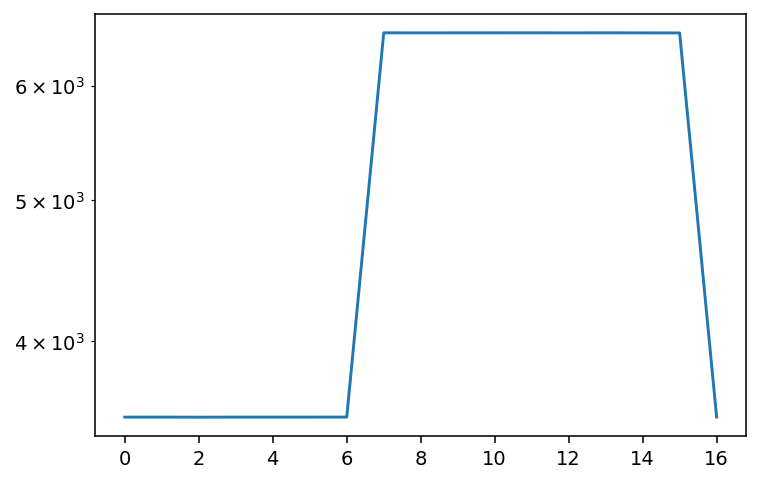

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 10
    # data points      = 1
    # variables        = 6
    chi-square         = 12560691.1
    reduced chi-square = 12560691.1
    Akaike info crit   = 28.3460827
    Bayesian info crit = 16.3460827
##  Warning: uncertainties could not be estimated:
    f0:  at initial value
    f1:  at initial value
    f2:  at initial value
[[Variables]]
    f0:  0.34816847 +/- 22630622.2 (6499905742.60%) (init = 0.3481685)
    b0:  1.570796 (fixed)
    a0:  0.00000000 +/-        nan (nan%) (init = 0)
    f1:  0.08641450 +/-        nan (nan%) (init = 0.0864145)
    b1:  3.141593 (fixed)
    a1:  0.00000000 +/-        nan (nan%) (init = 0)
    f2:  0.06610393 +/-        nan (nan%) (init = 0.06610393)
    b2:  0 (fixed)
    a2:  0.00000000 +/-        nan (nan%) (init = 0)


In [47]:
# Now try to actually perform some optimization to get a better result

# Which parameters to actually fit
parametersToFit = ['f', 'a']

optimizedForceArr = np.array([np.zeros(len(forceGuessArr[i])) for i in range(len(centers))], dtype='object')
optimizedBetaArr = np.array([np.zeros(len(forceGuessArr[i])) for i in range(len(centers))], dtype='object')
optimizedAlphaArr = np.array([np.zeros(len(forceGuessArr[i])) for i in range(len(centers))], dtype='object')

residuals = []

# Setup our function based on what parameters we are fitting
# We want to avoid any if statements within the function itself, since
# that will be evaluated many many times
def objectiveFunction(params, trueImage, z, radius, center):
    forceArr = np.array([params[f"f{j}"] for j in range(z)])
    betaArr = np.array([params[f"b{j}"] for j in range(z)])
    alphaArr = np.array([params[f"a{j}"] for j in range(z)])

    synImage = genSyntheticResponse(forceArr, alphaArr, betaArr, fSigma, radius, pxPerMeter, brightfield, imageSize=imageShape[:2], center=center)
    
    clear_output(wait=True)
    residuals.append(np.sum(np.abs(synImage - trueImage)))
    plt.plot(residuals)
    plt.yscale('log')
    plt.show()
    
    return np.sum(np.abs(synImage - trueImage))


for i in range(len(centers)):

    # Setup our real image
    particleMask = circularMask(photoelasticChannel.shape, centers[i], radii[i])[:,:,0]
    realImage = photoelasticChannel * particleMask

    angleBounds = (-np.pi, np.pi)
    strictAngleBounds = (-np.pi/8., np.pi/8.) # Alpha really shouldn't change that much
    forceBounds = (0, 1)

    # Out fitting parameters
    # if vary kwarg is false, that value won't be fit
    params = Parameters()
    z = len(forceGuessArr[i])
    for j in range(z):
        params.add(f'f{j}', value=forceGuessArr[i][j], vary='f' in parametersToFit, min=forceBounds[0], max=forceBounds[1])
        params.add(f'b{j}', value=betaGuessArr[i][j], vary='b' in parametersToFit, min=angleBounds[0], max=angleBounds[1])
        params.add(f'a{j}', value=alphaGuessArr[i][j], vary='a' in parametersToFit, min=strictAngleBounds[0], max=strictAngleBounds[1])

    #params.pretty_print()
    

    # Now do the optimization
    result = minimize(objectiveFunction, params,
                     args=(realImage, z, radii[i], centers[i]),
                     method='least_squares')
        
    #result.params.pretty_print()
    optimizedForceArr[i] = np.array([result.params[f"f{j}"] for j in range(z)])
    optimizedBetaArr[i] = np.array([result.params[f"b{j}"] for j in range(z)])
    optimizedAlphaArr[i] = np.array([result.params[f"a{j}"] for j in range(z)])

    break

print(fit_report(result))

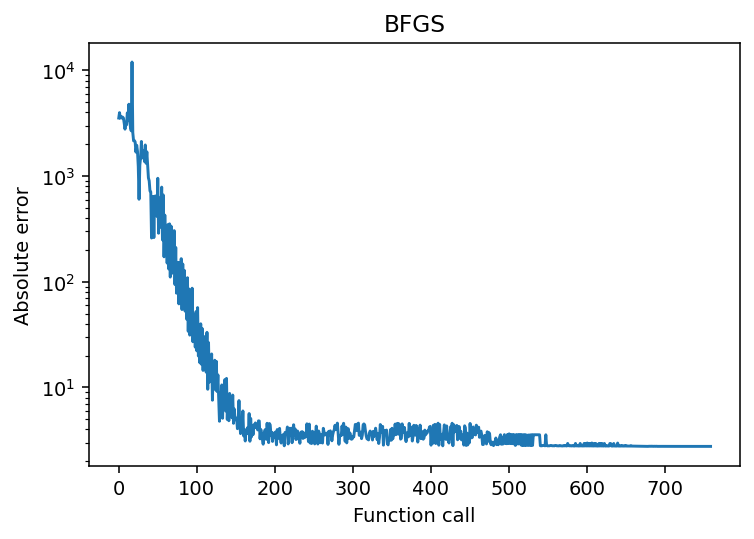

In [39]:
plt.plot(residuals)
plt.xlabel('Function call')
plt.ylabel('Absolute error')
plt.yscale('log')
plt.title('lbfgsb')

#plt.savefig('lbfgsb.png')
plt.show()

2.763396527839745


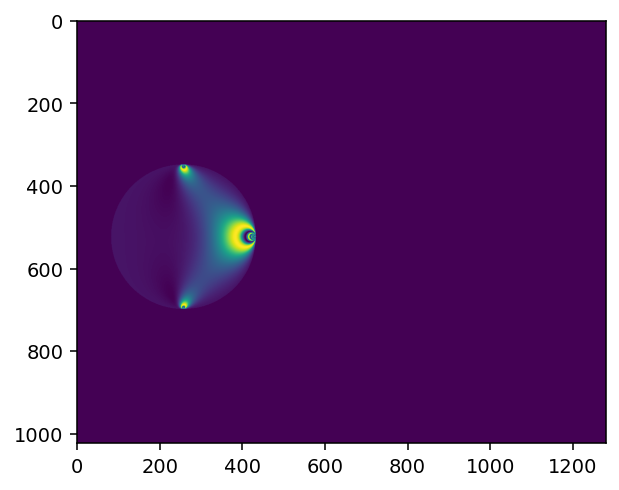

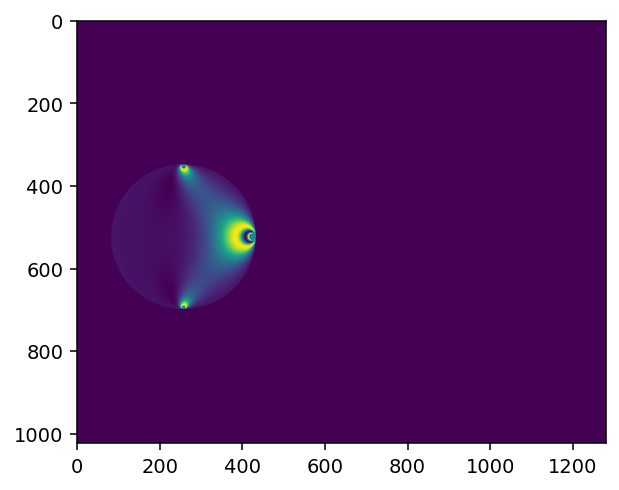

In [40]:
testImage = genSyntheticResponse(np.array(optimizedForceArr[0]), np.array(optimizedAlphaArr[0]), np.array(optimizedBetaArr[0]), fSigma, radii[0], pxPerMeter, brightfield, imageSize=imageShape[:2], center=centers[0])
print(np.sum(np.abs(testImage - realImage)))
plt.imshow(testImage)
plt.show()
plt.imshow(realImage)
plt.show()

In [ ]:
print(alphaGuessArr - optimizedAlphaArr, '\n')
print(betaGuessArr - optimizedBetaArr, '\n')
print(forceGuessArr - optimizedForceArr, '\n')

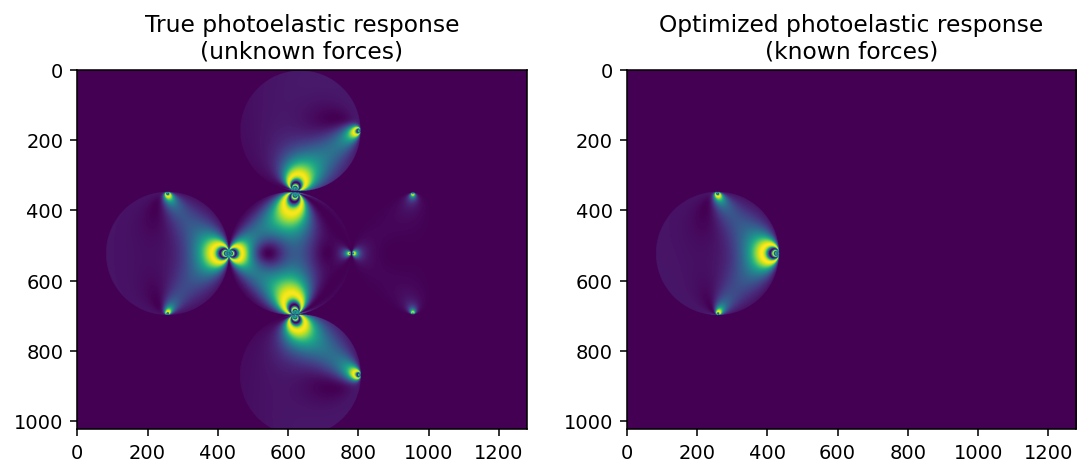

-63825.22875954941


In [36]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(photoelasticChannel)
ax[0].set_title('True photoelastic response\n(unknown forces)')

optimizedPhotoelasticChannel = np.zeros(imageShape[:2])

for i in range(len(centers)):
    optimizedPhotoelasticChannel += genSyntheticResponse(np.array(optimizedForceArr[i]),
                                                         np.array(optimizedAlphaArr[i]),
                                                         np.array(optimizedBetaArr[i]),
                                                         fSigma, radii[i], pxPerMeter, brightfield, imageSize=imageShape[:2], center=centers[i])


ax[1].imshow(optimizedPhotoelasticChannel)
ax[1].set_title('Optimized photoelastic response\n(known forces)')

fig.tight_layout()
plt.show()

print(np.sum(optimizedPhotoelasticChannel - photoelasticChannel))

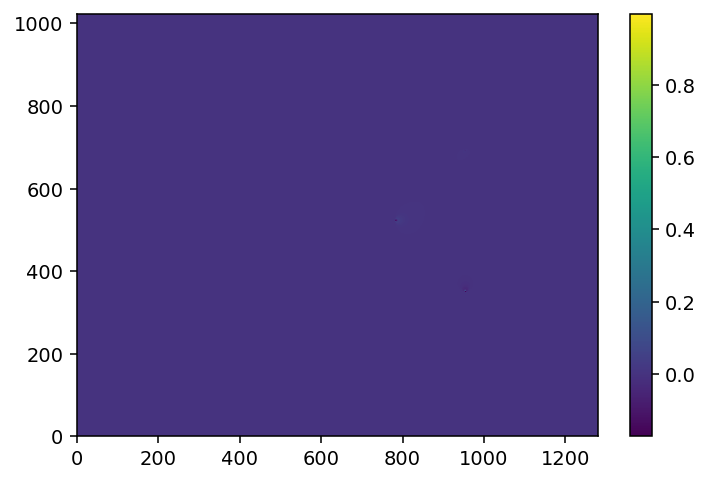

In [10]:
plt.pcolor(optimizedPhotoelasticChannel - estimatedPhotoelasticChannel)
plt.colorbar()
plt.show()

In [ ]:
# This is (mostly) the algorithm inside of initialForceSolve, which I've keep
# here in case anything needs to be tested.

# Now we want to come up with an initial guess for forces, betas and alphas

# First, identify how many forces are acting on each particle
numParticles = len(centers)
betaGuessArr = [np.empty(0) for i in range(numParticles)]

# Interparticle contacts
# np.eye is the identity, which removes the diagonal entries
adjMat = adjacencyMatrix(centers, radii, contactPadding) - np.eye(numParticles)

# This includes duplicates, but that is ok because as long as we keep
# the index order consistent, each force will show up only once for each particle
# (but twice overall, which is what we want)
contacts = np.transpose(np.where(adjMat))

# Each pair of indices
for p in contacts:
    betaGuessArr[p[0]] = np.append(betaGuessArr[p[0]], np.arctan2(centers[p[1]][1] - centers[p[0]][1], centers[p[1]][0] - centers[p[0]][0]))

# Now look at wall contacts
numWallContacts, wallBetaArr, wallG2AvgArr = detectWallContacts(centers, radii, maskArr, contactPadding=contactPadding)
for i in range(numParticles):
    for j in range(numWallContacts[i]):
        betaGuessArr[i] = np.append(betaGuessArr[i], wallBetaArr[i][j])
    
print(betaGuessArr)

# Alpha is very easy: we just assume all forces are radial
# This creates an empty array the same shape as the beta one,
# but with all of the values set to 0
alphaGuessArr = np.zeros(len(betaGuessArr), dtype='object')
for i in range(len(alphaGuessArr)):
    alphaGuessArr[i] = np.zeros(len(betaGuessArr[i]))

# Initialize force the same way, but this will end up with
# actual values
forceGuessArr = np.zeros(len(betaGuessArr), dtype='object')
for i in range(len(forceGuessArr)):
    forceGuessArr[i] = np.zeros(len(betaGuessArr[i]))
    

# For the force magnitudes, we need to use g2
# Calibration value
# Take the mean of the radii for this, since they should all be around the same
# radius, but the detection might have a little variation
g2Cal = g2ForceCalibration(fSigma, np.mean(radii), pxPerMeter, brightfield=brightfield)
gSqr = gSquared(photoelasticChannel)

for i in range(numParticles):
    g2Mask = circularMask(photoelasticChannel.shape, centers[i], radii[i] - g2MaskPadding)[:,:,0]

    avgGSqr = np.sum(gSqr * g2Mask) / np.sum(g2Mask)

    # Now allocate this force to each contact
    contactG2Arr = np.zeros(len(forceGuessArr[i]))
    # Now we have to find the average gsqr at each contact
    for j in range(len(forceGuessArr[i])):
        contactMask = circularMask(photoelasticChannel.shape,
                                   centers[i] + radii[i]*np.array([np.cos(betaGuessArr[i][j]), np.sin(betaGuessArr[i][j])]),
                                  contactMaskRadius)[:,:,0]
        # Now make sure it stays within the particle
        contactMask = 1 - np.int16((contactMask + g2Mask - 2) > 0)

        contactG2Arr[j] = np.sum(gSqr * contactMask) / np.sum(contactMask)

    forceGuessArr[i][:] = avgGSqr * contactG2Arr / np.sum(contactG2Arr) / g2Cal
